In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [4]:
import pandas as pd

In [5]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [26]:
data = pd.read_csv("data_capec.csv")
data['text'] = data["text"].str.replace('/',' ')
X = data["text"]
y = data["label"]

# Tiền xử lý dữ liệu
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=200)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
rlist =['66 - SQL Injection', '000 - Normal','194 - Fake the Source of Data','34 - HTTP Response Splitting',
'126 - Path Traversal',
'242 - Code Injection',
'272 - Protocol Manipulation',
'310 - Scanning for Vulnerable Software',
'153 - Input Data Manipulation']


In [28]:
mapping = {l: i for i, l in enumerate(rlist)}
mapping

{'66 - SQL Injection': 0,
 '000 - Normal': 1,
 '194 - Fake the Source of Data': 2,
 '34 - HTTP Response Splitting': 3,
 '126 - Path Traversal': 4,
 '242 - Code Injection': 5,
 '272 - Protocol Manipulation': 6,
 '310 - Scanning for Vulnerable Software': 7,
 '153 - Input Data Manipulation': 8}

In [29]:
y_train = [mapping[s] for s in y_train] 
y_test = [mapping[r] for r in y_test]  

In [30]:
from keras.utils.np_utils import to_categorical
import numpy as np
y_train = np.array(y_train)
y_test = np.array(y_test)

In [31]:
maxlen=200
vocab_size = 20000  

In [32]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
y_train

array([1, 0, 2, ..., 0, 0, 0])

In [34]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test)
)

Epoch 1/2
9071/9071 [==============================] - 638s 70ms/step - loss: 0.1225 - accuracy: 0.9640 - val_loss: 0.0537 - val_accuracy: 0.9830
Epoch 2/2
9071/9071 [==============================] - 655s 72ms/step - loss: 0.0532 - accuracy: 0.9835 - val_loss: 0.0497 - val_accuracy: 0.9848


In [35]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)


2268/2268 [==============================] - 47s 21ms/step


In [36]:
y_predict = np.argmax(y_pred, axis=1)
y_predict

array([0, 1, 0, ..., 2, 0, 2], dtype=int64)

In [37]:
print(classification_report(y_test, y_predict, target_names=rlist, labels= range(10)))

                                        precision    recall  f1-score   support

                    66 - SQL Injection       0.97      1.00      0.99     36682
                          000 - Normal       0.98      0.97      0.98     17959
         194 - Fake the Source of Data       1.00      0.98      0.99      8644
          34 - HTTP Response Splitting       1.00      1.00      1.00      3708
                  126 - Path Traversal       1.00      0.99      0.99      2312
                  242 - Code Injection       0.99      0.99      0.99      1969
           272 - Protocol Manipulation       0.91      0.74      0.82       584
310 - Scanning for Vulnerable Software       0.96      0.94      0.95       485
         153 - Input Data Manipulation       0.00      0.00      0.00       219

                             micro avg       0.98      0.98      0.98     72562
                             macro avg       0.78      0.76      0.77     72562
                          weighted avg

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2326: UserWarning: labels size, 10, does not match size of target_names, 9
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: Undefine

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
import seaborn as sns
import matplotlib.pyplot as plt

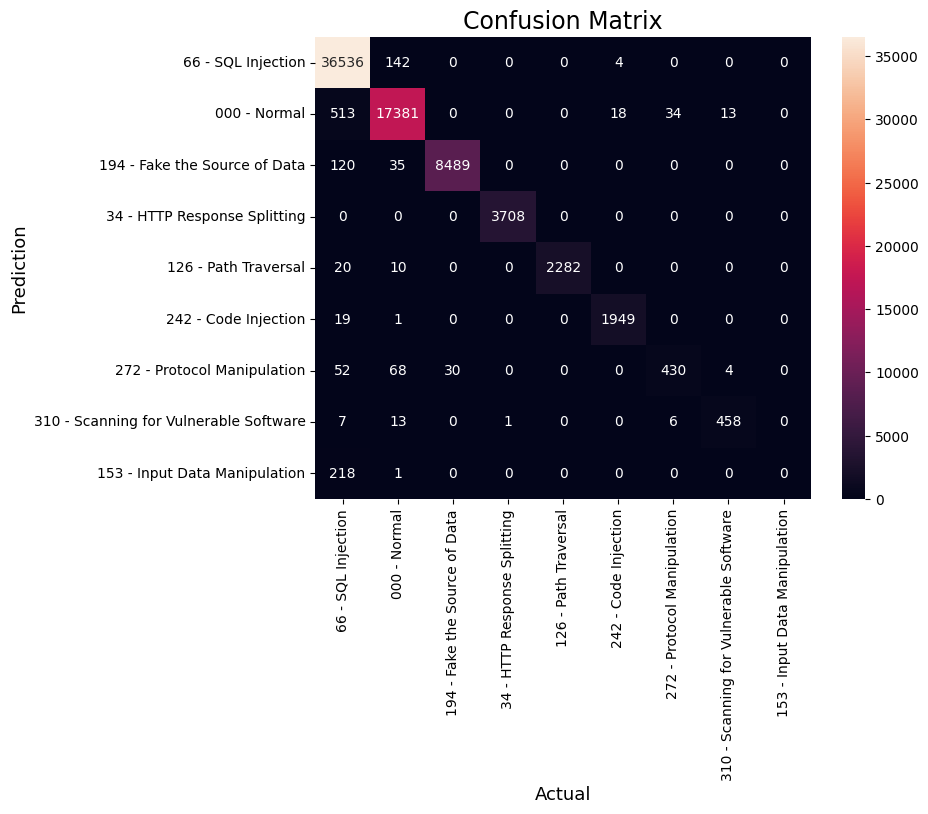

In [39]:
plt.figure(figsize=(8,6))

sns.heatmap(cm,
            annot=True,
            fmt='g', xticklabels=rlist, yticklabels= rlist)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

plt.show()